# Simple Recurrent Model

Using the class-balanced data.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the SEQ_LEN by 50%.

In [ ]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'tokenized'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

Imports and colab setup

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb

`wandb` log in:

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Google drive access

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [ ]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text utils to be instantianted in the notebook

In [ ]:
notebook_model = avm.LitEmbeddingRNNAV
notebook_datamodule = avm.EmbeddingDataModuleAV
notebook_encoder = avm.string_to_idxs 
notebook_decoder = avm.idxs_to_string 
notebook_wandb_pred_callback = avm.WandbAVPredictionCallback
notebook_wandb_embedding_callback = avm.WandbVisualEmbeddingCallback

Copy data to cwd for speed.

In [ ]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)
if TEXT_ENCODING == 'one-hot':
    text_to_idx = dict(zip(tokens_df.char.values, np.arange(len(tokens_df))))
else:
    # 0 and 1 are reserved for padding and <UNK> for embeddings and not included
    # in tokens_df
    text_to_idx = dict(zip(tokens_df.word.values, np.arange(2, len(tokens_df) + 2)))
    text_to_idx['<PAD>'] = 0
    text_to_idx['<UNK>'] = 1
idx_to_text = {val: key for key, val in text_to_idx.items()}
with open(FOLDERNAME + SUBDIR + 'heatmap_words.txt', 'r') as f:
    heatmap_words = f.read().split()
with open(FOLDERNAME + SUBDIR + 'pca_words.txt', 'r') as f:
    pca_words =f.read().split()
with open(FOLDERNAME + SUBDIR + 'tsne_words.txt', 'r') as f:
    tsne_words = f.read().split()

The `tokens_df` used for embedding layers currently has every word found in the training set, regardless of length or how common it is. Many words are rarely used:

In [ ]:
tokens_df.describe()

,count
count,23946.000000
mean,14.654640
std,209.052981
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,16881.000000


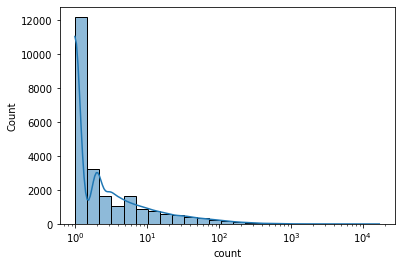

In [ ]:
sns.histplot(data=tokens_df, x='count', kde=True, bins=25, log_scale=True)

Plot what percent of all words and what percent of entries in the training set are removed if we only include words which appear more than `n` times, for varying choices of `n`:

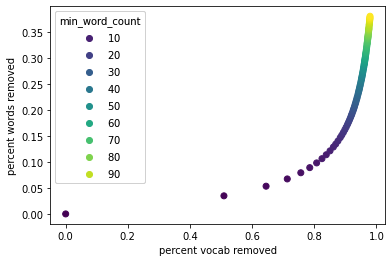

In [ ]:
def vocab_words_removed(n, df):
    df = df.copy()
    filtered_df = df.loc[lambda x: x['count'] >= n]
    vocab_pct_removed = 1- len(filtered_df) / len(df)
    words_pct_removed = 1 - filtered_df['count'].sum() / df['count'].sum()
    return (vocab_pct_removed, words_pct_removed)

removed_data = [vocab_words_removed(n, tokens_df) for n in range(1, 100)]
fig, ax = plt.subplots(1, 1)
scatter = ax.scatter(*zip(*removed_data),
                     c=np.arange(1, len(removed_data) + 1),
                     cmap='viridis')
ax.set_xlabel('percent vocab removed')
ax.set_ylabel('percent words removed')
legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="upper left", 
                    title="min_word_count")
ax.add_artist(legend1)
fig.savefig(FOLDERNAME + '/figures/embedding_vocab_words_removed_plot.svg')

We can pass a `min_word_count` arg (default `1`) to the architecture and datamodules which will filter the vocab to only include words with `count >= min_word_count` `tokens_df`. (This filtering crucially assumes lower-indexed words have a higher count than higher-indexed ones).

In [ ]:
MIN_WORD_COUNT = 1
print(vocab_words_removed(MIN_WORD_COUNT, tokens_df))

(0.0, 0.0)


Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [ ]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Thu Jan 13 18:15:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [ ]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

balanced_title_recurrent_embedding


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [ ]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[TEXT_FIELD], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [ ]:
print(train_data_df.head().to_string())

                                                                                                title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [ ]:
model_args_dict = {'seq_len': SEQ_LEN,
                  'min_word_count': MIN_WORD_COUNT,
                  'tokens': tokens_df,
                  'num_layers': 2,
                  'hidden_size': 512,
                  'rnn_type': 'GRU',
                  'bidirectional': True,
                  'hidden_strategy': 'concat',
                  'embedding_dim': 256,
                  'zero_fc_bias_init': True,
                  'lr_scheduler': 'plateau',
                  'lr_scheduler_args': {'verbose': True,
                                        'patience': 1,
                                        'factor': .1}
                  }
data_args_dict = {'seq_len': SEQ_LEN,
                  'min_word_count': MIN_WORD_COUNT,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'tokens': tokens_df, 
                 'text_column': TEXT_FIELD,
                 'num_workers': NUM_PROCESSORS,
                 'batch_size': 128,
                 'pin_memory': IS_CUDA_AVAILABLE,
                 'persistent_workers': True
                 }

Small test run.

In [ ]:
small_data_module = notebook_datamodule(**{**data_args_dict, **{'sample_size': .5}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, idx_to_text).strip()
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**model_args_dict)
print('Model layers:', small_model)
small_preds, small_losses, _ = small_model.scores_loss_hiddens(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', -np.log(.5))

text: curricular perspectives and strategies for developing cognitive skills in early education
len: 89
source: True
text: physics predict crowd behavior
len: 30
source: True
text: the x - ray cavity around hotspot e in cygnus a : tunneled by a deflected jet
len: 77
source: False


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



Model layers: LitEmbeddingRNNAV(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Linear(in_features=3072, out_features=1, bias=True)
  )
)

preds shape: torch.Size([128])

actual loss: 0.6909930109977722

expected approx loss 0.6931471805599453


In [ ]:
# pl implements gradient clipping through the Trainer.
small_trainer = Trainer(gpus=-1 if IS_CUDA_AVAILABLE else 0,
                        max_epochs=1,
                        gradient_clip_val=1
                        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_ff7fedfe-ca0c-4205-845c-78d298947f8d.ckpt


Suggested lr: 0.0003981071705534973


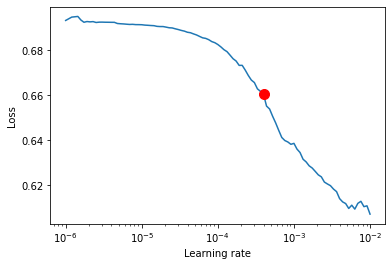

In [ ]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module, min_lr=1e-6, max_lr=1e-2)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
small_trainer_suggested_lr = small_trainer_lr_finder.suggestion()
print(f'Suggested lr: {small_trainer_suggested_lr}')

In [ ]:
small_trainer.fit(small_model, datamodule=small_data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                    | Type             | Params
--------------------------------------------------------------
0  | train_acc               | Accuracy         | 0     
1  | val_acc                 | Accuracy         | 0     
2  | test_acc                | Accuracy         | 0     
3  | train_precision         | Precision        | 0     
4  | val_precision           | Precision        | 0     
5  | test_precision          | Precision        | 0     
6  | train_recall            | Recall           | 0     
7  | val_recall              | Recall           | 0     
8  | test_recall             | Recall           | 0     
9  | train_specificity       | Specificity      | 0     
10 | val_speci

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.



# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `sweep_fixed_model_args_dict`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `sweep_fixed_model_args_dict` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [ ]:
sweep_fixed_model_args_dict = {**deepcopy(model_args_dict), 
                               **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'min': np.log(small_trainer_suggested_lr / 2).item(),
                                      'max': np.log(small_trainer_suggested_lr * 2).item()
                                      },
                               'l2_reg': {'distribution': 'log_uniform',
                                              'min': np.log(1e-2).item(),
                                              'max': np.log(1.).item(),},
                               'fc_dropout': {'distribution': 'uniform',
                                              'min': .6,
                                              'max': .9},
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `sweep_fixed_model_args_dict` for logging purposes.

In [ ]:
# Setting 'batch_size' in sweep_data_args_dict controls the batch size, while setting
# this key in sweep_fixed_model_args_dict just lets wandb track this hyperparameter.
sweep_data_args_dict = deepcopy(data_args_dict)
sweep_data_args_dict['batch_size'] = sweep_fixed_model_args_dict['batch_size'] = 2048

# Set max_epochs in a dict, along with any other optional trainer kwargs.
sweep_trainer_dict = {'max_epochs': 32,
                      'gradient_clip_val': 1,
                      }

# Merge sweep_trainer_dict into sweep_fixed_model_args_dict for logging purposes.
sweep_fixed_model_args_dict = {**sweep_fixed_model_args_dict, **sweep_trainer_dict}

def sweep_val_examples(sample_size=512,
                       datamodule_args=sweep_data_args_dict):
    """Taking random samples from the validation set for callback visualization.
    """
    val_sample_module = notebook_datamodule(**{**datamodule_args,
                                               **{'sample_size': sample_size}})
    val_sample_module.setup()
    val_sample  = next(iter(val_sample_module.val_dataloader()))
    return val_sample

def sweep_trainer(model):
    """Encapsulating the trainer used for wandb sweeps.
    """
    trainer = Trainer(logger=WandbLogger(),
                      gpus=-1 if IS_CUDA_AVAILABLE else 0,
                      log_every_n_steps=5,
                      callbacks=[notebook_wandb_pred_callback(val_sample=sweep_val_examples(),
                                                         decoder_fn=notebook_decoder,
                                                         decoder_dict=idx_to_text,
                                                         labels=('arxiv', 'vixra')),
                                 EarlyStopping(monitor='val_acc',
                                               mode='max',
                                               check_on_train_epoch_end=False,
                                               patience=5,
                                               verbose=True),
                                 notebook_wandb_embedding_callback(model=model,
                                                    heatmap_words=heatmap_words,
                                                    pca_words=pca_words,
                                                    tsne_words=tsne_words,
                                                    word_to_idx=text_to_idx,
                                                    idx_to_word=idx_to_text,
                                                    k=5,
                                                    heatmap_title=f'{PROJECT} Cosine Heatmap',
                                                    pca_title=f'{PROJECT} PCA',
                                                    tsne_title=f'{PROJECT} t-SNE',
                                                    )
                                 ],
                      num_sanity_val_steps=-1,
                      **sweep_trainer_dict
                      )
    return trainer

def sweep_iteration():
    """The wandb sweep iteration function. To be passed to wandb.agent.
    """
    # There seems to be a 128 char limit on the group_str
    group_str = '-'.join(sorted([f'{key}_{val}' for key, val in sweep_fixed_model_args_dict.items() if key != 'tokens']))[:128]
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**sweep_data_args_dict)
        config = wandb.config
        # Overwrite the random run names chosen by wandb.
        run.name = '-'.join(sorted([f'{key}_{val}' for key, val in config.items()]))[:128]
        # Merge config into remaining parameters.
        config = {**sweep_fixed_model_args_dict, **config}
        model = notebook_model(**config)
        print(50 * '-',
              'Model Architecture:',
              model,
              50 * '-',
              sep='\n')
        trainer = sweep_trainer(model)
        trainer.fit(model, 
                    datamodule=data)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: pn1x2s1t
Sweep URL: https://wandb.ai/garrett361/balanced_title_recurrent_embedding/sweeps/pn1x2s1t


In [ ]:
wandb.agent(sweep_id, function=sweep_iteration, count=5)
# Sweeps will generate a huge number of plots, if not closed.
plt.close("all")

wandb: Agent Starting Run: qoqeb01k with config:
wandb: 	fc_dropout: 0.7271487658747257
wandb: 	l2_reg: 0.07254420859730379
wandb: 	lr: 0.0005091619228201495
wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.7271487658747257, inplace=False)
    (1): Linear(in_features=3072, out_features=1, bias=True)
  )
)
-----

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'l2_reg' was locked by 'sw

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.7211917042732239
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.7211917042732239


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7215544581413269
Validation Loss: 0.5258955359458923
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7215544581413269
Validation Loss: 0.5258955359458923


Metric val_acc improved. New best score: 0.722
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.7709668874740601
Validation Loss: 0.4920448064804077
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7709668874740601
Validation Loss: 0.4920448064804077


Metric val_acc improved by 0.049 >= min_delta = 0.0. New best score: 0.771
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.7795138955116272
Validation Loss: 0.448007732629776
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.7795138955116272
Validation Loss: 0.448007732629776


Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.780
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.8092948794364929
Validation Loss: 0.4436779022216797
Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.8092948794364929
Validation Loss: 0.4436779022216797


Metric val_acc improved by 0.030 >= min_delta = 0.0. New best score: 0.809
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.8241186141967773
Validation Loss: 0.4235094487667084
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.8241186141967773
Validation Loss: 0.4235094487667084


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

Metric val_acc improved by 0.015 >= min_delta = 0.0. New best score: 0.824
/content/drive/My Drive/ML/arxiv_vixra/arxiv_vixra_models/embedding_utils.py:150: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) 

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 107
Epoch: 5
Validation accuracy: 0.823851466178894
Validation Loss: 0.40782612562179565


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 7
Validation accuracy: 0.8278579115867615
Validation Loss: 0.43257278203964233


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch     8: reducing learning rate of group 0 to 5.0916e-05.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 161
Epoch: 8
Validation accuracy: 0.8345352411270142
Validation Loss: 0.46129465103149414


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    10: reducing learning rate of group 0 to 5.0916e-06.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 197
Epoch: 10
Validation accuracy: 0.835603654384613
Validation Loss: 0.46566396951675415


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    12: reducing learning rate of group 0 to 5.0916e-07.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    14: reducing learning rate of group 0 to 5.0916e-08.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    16: reducing learning rate of group 0 to 5.0916e-09.


best_val_acc,▁▄▅▆▇▇▇█████████
best_val_loss,█▆▃▃▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇████
train_acc,▁▃▄▅▅▆▇▇████████
train_auc_roc,▁▄▅▆▆▇▇▇████████
train_average_precision,▁▄▅▆▆▇▇▇████████
train_f1,▁▄▅▅▆▆▇▇████████
train_loss,█▆▆▅▄▄▃▂▂▁▁▁▁▁▁▁
train_precision,▁▃▄▄▅▆▆▇▇███████
train_recall,▁▄▅▅▆▆▇▇████████


wandb: Agent Starting Run: tnl8cwhd with config:
wandb: 	fc_dropout: 0.6909574149607167
wandb: 	l2_reg: 0.01924029867772903
wandb: 	lr: 0.0005495568617051874


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.6909574149607167, inplace=False)
    (1): Linear(in_features=3072, out_features=1, bias=True)
  )
)
-----

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'l2_reg' was locked by 'sw

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6992992758750916
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.6992992758750916


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7215544581413269
Validation Loss: 0.51302170753479
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7215544581413269
Validation Loss: 0.51302170753479


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.7678952813148499
Validation Loss: 0.46496376395225525
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7678952813148499
Validation Loss: 0.46496376395225525


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.7907318472862244
Validation Loss: 0.4336795210838318
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.7907318472862244
Validation Loss: 0.4336795210838318


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.8023504018783569
Validation Loss: 0.4191180169582367
Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.8023504018783569
Validation Loss: 0.4191180169582367


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.8215811848640442
Validation Loss: 0.40367522835731506
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.8215811848640442
Validation Loss: 0.40367522835731506


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 5
Validation accuracy: 0.8255876302719116
Validation Loss: 0.4223496615886688


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 6
Validation accuracy: 0.8285256624221802
Validation Loss: 0.41667550802230835


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch     7: reducing learning rate of group 0 to 5.4956e-05.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 7
Validation accuracy: 0.836271345615387
Validation Loss: 0.4085502624511719


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch     9: reducing learning rate of group 0 to 5.4956e-06.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 197
Epoch: 10
Validation accuracy: 0.8369390964508057
Validation Loss: 0.42909669876098633


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    11: reducing learning rate of group 0 to 5.4956e-07.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 215
Epoch: 11
Validation accuracy: 0.8372061848640442
Validation Loss: 0.4292464852333069


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 233
Epoch: 12
Validation accuracy: 0.8374732732772827
Validation Loss: 0.4292041063308716


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    13: reducing learning rate of group 0 to 5.4956e-08.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    15: reducing learning rate of group 0 to 5.4956e-09.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▄▅▆▇▇▇███████████
best_val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train_acc,▁▄▅▅▆▆▇███████████
train_auc_roc,▁▄▅▆▆▇▇███████████
train_average_precision,▁▄▅▆▆▇▇███████████
train_f1,▁▄▅▆▆▇▇███████████
train_loss,█▆▅▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁
train_precision,▁▃▄▅▅▆▇▇██████████
train_recall,▁▄▅▆▆▇▇███████████


wandb: Agent Starting Run: o375adne with config:
wandb: 	fc_dropout: 0.7440513360994554
wandb: 	l2_reg: 0.6493408978575953
wandb: 	lr: 0.00027730468742708094


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.7440513360994554, inplace=False)
    (1): Linear(in_features=3072, out_features=1, bias=True)
  )
)
-----

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'l2_reg' was locked by 'sw

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.9105455875396729
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.9105455875396729


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7108707427978516
Validation Loss: 0.6440860033035278
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7108707427978516
Validation Loss: 0.6440860033035278


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.7280982732772827
Validation Loss: 0.5448220372200012
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7280982732772827
Validation Loss: 0.5448220372200012


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.7696313858032227
Validation Loss: 0.504218578338623
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.7696313858032227
Validation Loss: 0.504218578338623


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.7859241366386414
Validation Loss: 0.45618370175361633
Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.7859241366386414
Validation Loss: 0.45618370175361633


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.7905982732772827
Validation Loss: 0.44230079650878906
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.7905982732772827
Validation Loss: 0.44230079650878906


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 5
Validation accuracy: 0.8235843777656555
Validation Loss: 0.41309282183647156
Saved best val_loss at global step: 107
Epoch: 5
Validation accuracy: 0.8235843777656555
Validation Loss: 0.41309282183647156


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 7
Validation accuracy: 0.8282585740089417
Validation Loss: 0.40893059968948364
Saved best val_loss at global step: 143
Epoch: 7
Validation accuracy: 0.8282585740089417
Validation Loss: 0.40893059968948364


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    10: reducing learning rate of group 0 to 2.7730e-05.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 197
Epoch: 10
Validation accuracy: 0.8340010643005371
Validation Loss: 0.4206443428993225


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 215
Epoch: 11
Validation accuracy: 0.8365384340286255
Validation Loss: 0.42177900671958923


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    12: reducing learning rate of group 0 to 2.7730e-06.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 233
Epoch: 12
Validation accuracy: 0.8372061848640442
Validation Loss: 0.4230799674987793


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    14: reducing learning rate of group 0 to 2.7730e-07.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    16: reducing learning rate of group 0 to 2.7730e-08.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    18: reducing learning rate of group 0 to 2.7730e-09.


best_val_acc,▁▂▄▅▅▇▇███████████
best_val_loss,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train_acc,▁▄▄▅▆▆▇▇▇▇████████
train_auc_roc,▁▄▅▅▆▇▇▇▇█████████
train_average_precision,▁▄▅▅▆▇▇▇▇█████████
train_f1,▁▅▅▆▆▇▇▇▇▇████████
train_loss,█▆▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
train_precision,▁▁▂▃▄▅▆▆▆▇▇███████
train_recall,▁▅▅▆▆▇▇▇▇▇████████


wandb: Agent Starting Run: udn1pzjz with config:
wandb: 	fc_dropout: 0.6441898979789753
wandb: 	l2_reg: 0.04160133124462483
wandb: 	lr: 0.0004230076591954702


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.6441898979789753, inplace=False)
    (1): Linear(in_features=3072, out_features=1, bias=True)
  )
)
-----

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'l2_reg' was locked by 'sw

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.7058169841766357
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.7058169841766357


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7272970080375671
Validation Loss: 0.532978892326355
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7272970080375671
Validation Loss: 0.532978892326355


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.7490651607513428
Validation Loss: 0.4904022812843323
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7490651607513428
Validation Loss: 0.4904022812843323


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.7859241366386414
Validation Loss: 0.451644629240036
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.7859241366386414
Validation Loss: 0.451644629240036


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.7693642973899841
Validation Loss: 0.4433232545852661


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.7733707427978516
Validation Loss: 0.43104618787765503


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 5
Validation accuracy: 0.816773533821106
Validation Loss: 0.404876172542572
Saved best val_loss at global step: 107
Epoch: 5
Validation accuracy: 0.816773533821106
Validation Loss: 0.404876172542572


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 6
Validation accuracy: 0.8278579115867615
Validation Loss: 0.4347885549068451


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch     8: reducing learning rate of group 0 to 4.2301e-05.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 161
Epoch: 8
Validation accuracy: 0.8346688151359558
Validation Loss: 0.4088085889816284


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 179
Epoch: 9
Validation accuracy: 0.8396100401878357
Validation Loss: 0.43123510479927063


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    10: reducing learning rate of group 0 to 4.2301e-06.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    12: reducing learning rate of group 0 to 4.2301e-07.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    14: reducing learning rate of group 0 to 4.2301e-08.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

best_val_acc,▁▂▅▅▅▇▇▇███████
best_val_loss,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_acc,▁▃▄▅▅▆▇▇▇██████
train_auc_roc,▁▄▅▆▆▇▇▇███████
train_average_precision,▁▄▅▆▆▇▇▇███████
train_f1,▁▄▅▆▆▆▇▇███████
train_loss,█▆▆▅▄▄▃▂▂▁▁▁▁▁▁
train_precision,▁▂▄▅▅▆▆▇▇██████
train_recall,▁▄▅▆▆▆▇▇▇██████


wandb: Agent Starting Run: a7diyaus with config:
wandb: 	fc_dropout: 0.8349285528190356
wandb: 	l2_reg: 0.25979890457402327
wandb: 	lr: 0.0003990733728970516


--------------------------------------------------
Model Architecture:
LitEmbeddingRNNAV(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (embedding): Embedding(23948, 256, padding_idx=0)
  (rnn): GRU(256, 512, num_layers=2, batch_first=True, bidirectional=True)
  (fc_layers): ModuleList(
    (0): Dropout(p=0.8349285528190356, inplace=False)
    (1): Linear(in_features=3072, out_features=1, bias=True)
  )
)
-----

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'l2_reg' was locked by 'sw

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.7785691022872925
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5025373697280884
Validation Loss: 0.7785691022872925


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 0
Validation accuracy: 0.7142093777656555
Validation Loss: 0.5695799589157104
Saved best val_loss at global step: 17
Epoch: 0
Validation accuracy: 0.7142093777656555
Validation Loss: 0.5695799589157104


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 1
Validation accuracy: 0.7558760643005371
Validation Loss: 0.50725257396698
Saved best val_loss at global step: 35
Epoch: 1
Validation accuracy: 0.7558760643005371
Validation Loss: 0.50725257396698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 2
Validation accuracy: 0.7831196784973145
Validation Loss: 0.47438928484916687
Saved best val_loss at global step: 53
Epoch: 2
Validation accuracy: 0.7831196784973145
Validation Loss: 0.47438928484916687


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 3
Validation accuracy: 0.7896634340286255
Validation Loss: 0.43553733825683594
Saved best val_loss at global step: 71
Epoch: 3
Validation accuracy: 0.7896634340286255
Validation Loss: 0.43553733825683594


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 4
Validation accuracy: 0.8088942170143127
Validation Loss: 0.42140883207321167
Saved best val_loss at global step: 89
Epoch: 4
Validation accuracy: 0.8088942170143127
Validation Loss: 0.42140883207321167


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 5
Validation accuracy: 0.8223824501037598
Validation Loss: 0.4309491813182831


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 125
Epoch: 6
Validation accuracy: 0.8155716061592102
Validation Loss: 0.4185451567173004


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 7
Validation accuracy: 0.8274572491645813
Validation Loss: 0.4117484390735626
Saved best val_loss at global step: 143
Epoch: 7
Validation accuracy: 0.8274572491645813
Validation Loss: 0.4117484390735626


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 161
Epoch: 8
Validation accuracy: 0.8277243375778198
Validation Loss: 0.4395431876182556


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 179
Epoch: 9
Validation accuracy: 0.8285256624221802
Validation Loss: 0.4200280010700226


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    10: reducing learning rate of group 0 to 3.9907e-05.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 197
Epoch: 10
Validation accuracy: 0.832932710647583
Validation Loss: 0.4523662030696869


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 215
Epoch: 11
Validation accuracy: 0.8344017267227173
Validation Loss: 0.4690285921096802


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    12: reducing learning rate of group 0 to 3.9907e-06.


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 233
Epoch: 12
Validation accuracy: 0.8345352411270142
Validation Loss: 0.46780797839164734


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    14: reducing learning rate of group 0 to 3.9907e-07.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    16: reducing learning rate of group 0 to 3.9907e-08.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (

Epoch    18: reducing learning rate of group 0 to 3.9907e-09.


best_val_acc,▁▃▅▅▇▇▇███████████
best_val_loss,█▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train_acc,▁▃▄▅▆▆▆▇▇▇████████
train_auc_roc,▁▄▅▅▆▇▇▇▇█████████
train_average_precision,▁▄▅▆▆▇▇▇▇█████████
train_f1,▁▄▅▆▆▇▇▇▇▇████████
train_loss,█▆▅▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁
train_precision,▁▂▃▄▅▆▆▆▇▇████████
train_recall,▁▄▅▆▆▆▇▇▇▇████████


# Load the Best Models

Load all runs recorded in `wandb` for this notebook.

In [ ]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_val_acc',
            'best_val_loss',
            'config', 
            'name', 
            'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if {'best_val_acc','best_val_loss'}.issubset(run_json.keys()):
        if run.config['save_models_to_wandb']:
            notebook_runs_dict['best_val_acc'].append(run_json['best_val_acc'])
            notebook_runs_dict['best_val_loss'].append(run_json['best_val_loss'])
            notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
            notebook_runs_dict['name'].append(run.name)
            notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
notebook_runs_df.head()

,best_val_acc,best_val_loss,config,name,wandb_path
0,0.846554,0.382084,"{'lr': 0.005062486582446775, 'l2_reg': 0.01757...",fc_dropout_0.944669557689955-l2_reg_0.01757407...,garrett361/balanced_title_recurrent_embedding/...
1,0.845486,0.413877,"{'lr': 0.0008124659843814654, 'l2_reg': 0.7932...",fc_dropout_0.9521615747156527-l2_reg_0.7932406...,garrett361/balanced_title_recurrent_embedding/...
2,0.842281,0.388410,"{'lr': 0.0003342530193554, 'l2_reg': 0.0002526...",fc_dropout_0.5048804478214595-l2_reg_0.0002526...,garrett361/balanced_title_recurrent_embedding/...
3,0.842014,0.409435,"{'lr': 0.0013296833540471938, 'l2_reg': 0.1130...",fc_dropout_0.8873679263353795-l2_reg_0.1130499...,garrett361/balanced_title_recurrent_embedding/...
4,0.841880,0.381726,"{'lr': 0.000282511904115681, 'l2_reg': 0.01963...",fc_dropout_0.7736786673746117-l2_reg_0.0196322...,garrett361/balanced_title_recurrent_embedding/...


Isolate the best models by `val_acc` and `val_loss`:

In [ ]:
best_val_acc_model_df = notebook_runs_df.iloc[notebook_runs_df['best_val_acc'].argmax()]
print(best_val_acc_model_df)

best_val_acc                                              0.846554
best_val_loss                                             0.382084
config           {'lr': 0.005062486582446775, 'l2_reg': 0.01757...
name             fc_dropout_0.944669557689955-l2_reg_0.01757407...
wandb_path       garrett361/balanced_title_recurrent_embedding/...
Name: 0, dtype: object


In [ ]:
best_val_loss_model_df = notebook_runs_df.iloc[notebook_runs_df['best_val_loss'].argmin()]
print(best_val_loss_model_df)

best_val_acc                                              0.837073
best_val_loss                                             0.372638
config           {'lr': 0.0003996460789948324, 'l2_reg': 0, 'fc...
name                                      lr_0.0003996460789948324
wandb_path       garrett361/balanced_title_recurrent_embedding/...
Name: 57, dtype: object


Save the state dicts locally and rebuild the corresponding models.

In [ ]:
for file_name, model in (('model_best_val_acc.pt', best_val_acc_model_df),
                         ('model_best_val_loss.pt', best_val_loss_model_df),):
    model_path = model.wandb_path
    # wandb also stores None values in the config dict as a string literal. Need to
    # fix these entries, annoyingly.
    for key, val in model.config.items():
        if val == 'None':
            model.config[key] = None
    # Write to disk
    wandb.restore(file_name, run_path=model_path, replace=True)
    file_suffix = file_name.split('_')[-1]
    !cp '{file_name}' "{FOLDERNAME + '/final_models/' + PROJECT + '_' + file_suffix}"

In [ ]:
# Need to restore the tokens arg which is not synced with wandb.
best_val_acc_model = notebook_model(**{**best_val_acc_model_df.config, **{'tokens': tokens_df}})
best_val_acc_model.load_state_dict(torch.load('model_best_val_acc.pt'))
best_val_loss_model = notebook_model(**{**best_val_loss_model_df.config, **{'tokens': tokens_df}})
best_val_loss_model.load_state_dict(torch.load('model_best_val_loss.pt'))

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



<All keys matched successfully>

# My Papers

Finally, examine the model's results on my own papers:

In [ ]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
goon_papers_df

,title,source
0,"quantum corrections to generic branes : dbi , ...",arxiv
1,universal relation between corrections to entr...,arxiv
2,primordial non - gaussianity,arxiv
3,"superluminality , black holes and eft",arxiv
4,shapes of gravity : tensor non - gaussianity a...,arxiv
5,the effective theory of shift - symmetric cosm...,arxiv
6,partially massless fields during inflation,arxiv
7,soft theorems for shift - symmetric cosmologies,arxiv
8,heavy fields and gravity,arxiv
9,aspects of galileon non - renormalization,arxiv


Encode titles, stack into a tensor, and generate predictions:

In [ ]:
# Need to rebuild the word_to_idx mappings based on model specifics.
for model_type, model in (('best_val_acc_model', best_val_acc_model),
                          ('best_val_loss_model', best_val_loss_model)):
    model_min_word_count = model.hparams.min_word_count
    model_max_embedding_idx = (tokens_df['count'] >= model_min_word_count).sum() + 1
    model_word_to_idx = {text: idx for text, idx in text_to_idx.items() if idx <= model_max_embedding_idx}
    goon_papers_t = torch.stack([tensor for tensor in goon_papers_df[TEXT_FIELD].apply(lambda x: notebook_encoder(x, model_word_to_idx, SEQ_LEN))], dim=0)
    model_probs_t = model.inference(goon_papers_t)
    goon_papers_df['vixra_prob_' + model_type] = model_probs_t
    print(f'Mean prediction of {model_type}: {model_probs_t.mean().item()}')
    print(f'Correct predictions from {model_type}: {(model_probs_t < .5).sum()}/{goon_papers_t.shape[0]}')

Mean prediction of best_val_acc_model: 0.2599080502986908
Correct predictions from best_val_acc_model: 15/20
Mean prediction of best_val_loss_model: 0.3990465998649597
Correct predictions from best_val_loss_model: 13/20


Visualized by title:

In [ ]:
goon_papers_df = goon_papers_df.sort_values(by='vixra_prob_best_val_acc_model', ascending=False).reset_index(drop=True)
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_df)

,title,source,vixra_prob_best_val_acc_model,vixra_prob_best_val_loss_model
0,"einstein gravity , massive gravity , multi - gravity and nonlinear realizations",arxiv,0.989960,0.972740
1,galileons as wess - zumino terms,arxiv,0.890615,0.732733
2,"superluminality , black holes and eft",arxiv,0.890231,0.601606
3,massive gravity coupled to galileons is ghost - free,arxiv,0.767902,0.582843
4,galileons coupled to massive gravity : general analysis and cosmological solutions,arxiv,0.695754,0.285897
5,symmetries for galileons and dbi scalars on curved space,arxiv,0.282837,0.146483
6,a new class of effective field theories from embedded branes,arxiv,0.279555,0.366412
7,universal relation between corrections to entropy and extremality,arxiv,0.200064,0.336123
8,shapes of gravity : tensor non - gaussianity and massive spin - 2 fields,arxiv,0.046536,0.373493
9,heavy fields and gravity,arxiv,0.032584,0.196061


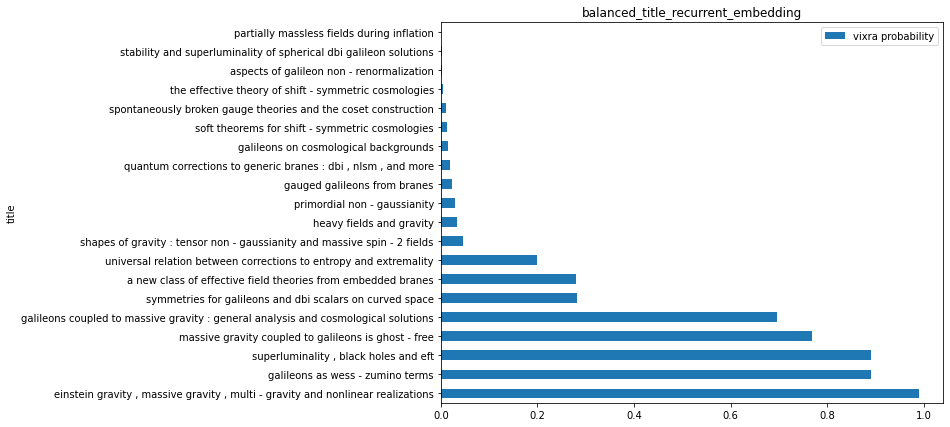

In [ ]:
goon_papers_df_barh = goon_papers_df.plot.barh(x='title',
                                               y='vixra_prob_best_val_acc_model', 
                                               title=PROJECT, 
                                               figsize=(9, 7),
                                               label='vixra probability',
                                               legend=True)
goon_papers_df_barh.figure.savefig(FOLDERNAME + f'/figures/{PROJECT}_goon_papers_preds.svg', bbox_inches='tight')

# Embedding Visualization

Compute the cosines bewteen all emedding vectors:

In [ ]:
best_val_acc_embedding = best_val_acc_model.embedding.weight.detach()
best_val_acc_embedding_inners = (best_val_acc_embedding @ best_val_acc_embedding.T)
# Add small constant to avoid dividing by zero due to padding zero vector.
best_val_acc_embedding_inners_norms = best_val_acc_embedding_inners.diag().sqrt() + 1e-10 
best_val_acc_embedding_inners_normalized = best_val_acc_embedding_inners / best_val_acc_embedding_inners_norms / best_val_acc_embedding_inners_norms[:, None]
torch.testing.assert_close(best_val_acc_embedding_inners_normalized.diagonal().sum(), torch.tensor(best_val_acc_embedding.shape[0] - 1.))

In [ ]:
best_val_acc_embedding_inners_normalized[15].topk(4).indices[1:]

tensor([ 356, 3421,  236])

In [ ]:
tokens_df.iloc[best_val_acc_embedding_inners_normalized[14].topk(10).indices[1:]]

,word,count
14712,powerfree,1
19552,superluminals,1
16076,ultrapower,1
15756,iphones,1
12187,upsets,1
12488,supercollider,1
3373,equilibria,10
13450,ethersupporting,1
19884,wielkiego,1
